# Introdução

Este projeto tem como objetivo realizar uma análise detalhada sobre o comportamento de compra dos clientes e o desempenho financeiro da empresa Y.Afisha, fornecendo informações essenciais para o planejamento estratégico de 2025. As métricas a serem estudadas incluem:

1) Como as pessoas usam o produto: Entender a forma como os clientes interagem com o produto, identificando padrões de uso e funcionalidades mais demandadas.

2) Quando as pessoas começam a comprar: Determinar o momento em que os clientes iniciam suas compras, o que pode ajudar a identificar tendências e otimizar campanhas de marketing.

3) Quanto dinheiro cada cliente traz para a empresa: Avaliar o valor gerado por cada cliente, auxiliando no cálculo do valor de vida útil do cliente (CLTV) e em estratégias de fidelização.

4) Quando as despesas serão cobertas: Analisar o ponto de equilíbrio financeiro da empresa, identificando o momento em que as receitas começam a cobrir as despesas operacionais.

Essas métricas são fundamentais para orientar as decisões gerenciais da empresa, com foco no crescimento sustentável e em estratégias financeiras eficientes para o ano de 2025.

# Passo 1: Carregamento e Preparação dos Dados

In [1]:
# Carregar as bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import sklearn
from sklearn.cluster import KMeans
import openpyxl
import json
import requests
from sklearn.linear_model import LinearRegression

# Carregar os datasets
visits_new = pd.read_csv('/datasets/visits_log_us.csv')
orders_new = pd.read_csv('/datasets/orders_log_us.csv')
costs_new = pd.read_csv('/datasets/costs_us.csv')

# Convertendo os nomes das colunas para snake_case
visits_new.columns = visits_new.columns.str.replace(' ', '_').str.lower()
orders_new.columns = orders_new.columns.str.replace(' ', '_').str.lower()
costs_new.columns = costs_new.columns.str.replace(' ', '_').str.lower()

# Verificar valores ausentes
visits_new.isnull().sum(), orders_new.isnull().sum(), costs_new.isnull().sum()

# Converter as colunas de data para datetime
visits_new['start_ts'] = pd.to_datetime(visits_new['start_ts'])
visits_new['end_ts'] = pd.to_datetime(visits_new['end_ts'])
orders_new['buy_ts'] = pd.to_datetime(orders_new['buy_ts'])
costs_new['dt'] = pd.to_datetime(costs_new['dt'])

In [2]:
print("Visitas - Colunas e Tipos de Dados:")
print(visits_new.dtypes)
print("\nPrimeiras Linhas de 'visits_new':")
print(visits_new.head())

print("\n" + "="*50 + "\n")

print("Pedidos - Colunas e Tipos de Dados:")
print(orders_new.dtypes)
print("\nPrimeiras Linhas de 'orders_new':")
print(orders_new.head())

print("\n" + "="*50 + "\n")

print("Custos - Colunas e Tipos de Dados:")
print(costs_new.dtypes)
print("\nPrimeiras Linhas de 'costs_new':")
print(costs_new.head())



Visitas - Colunas e Tipos de Dados:
device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object

Primeiras Linhas de 'visits_new':
    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  


Pedidos - Colunas e Tipos de Dados:
buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

Primeiras Linhas de 'orders_new':
               buy_ts  revenue                   uid
0 2017-06-

# Passo 2. Relatórios e calcule as métricas do produto:

Agora que os dados estão prontos, podemos passar para a análise das métricas que nos ajudarão a entender melhor o comportamento dos usuários e a performance das campanhas de marketing.

Para avaliar como os usuários estão interagindo com a plataforma, vamos calcular algumas métricas de uso, como o número de usuários ativos diários, semanais e mensais, a quantidade de sessões por dia, o comprimento das sessões e a frequência de retorno dos usuários.

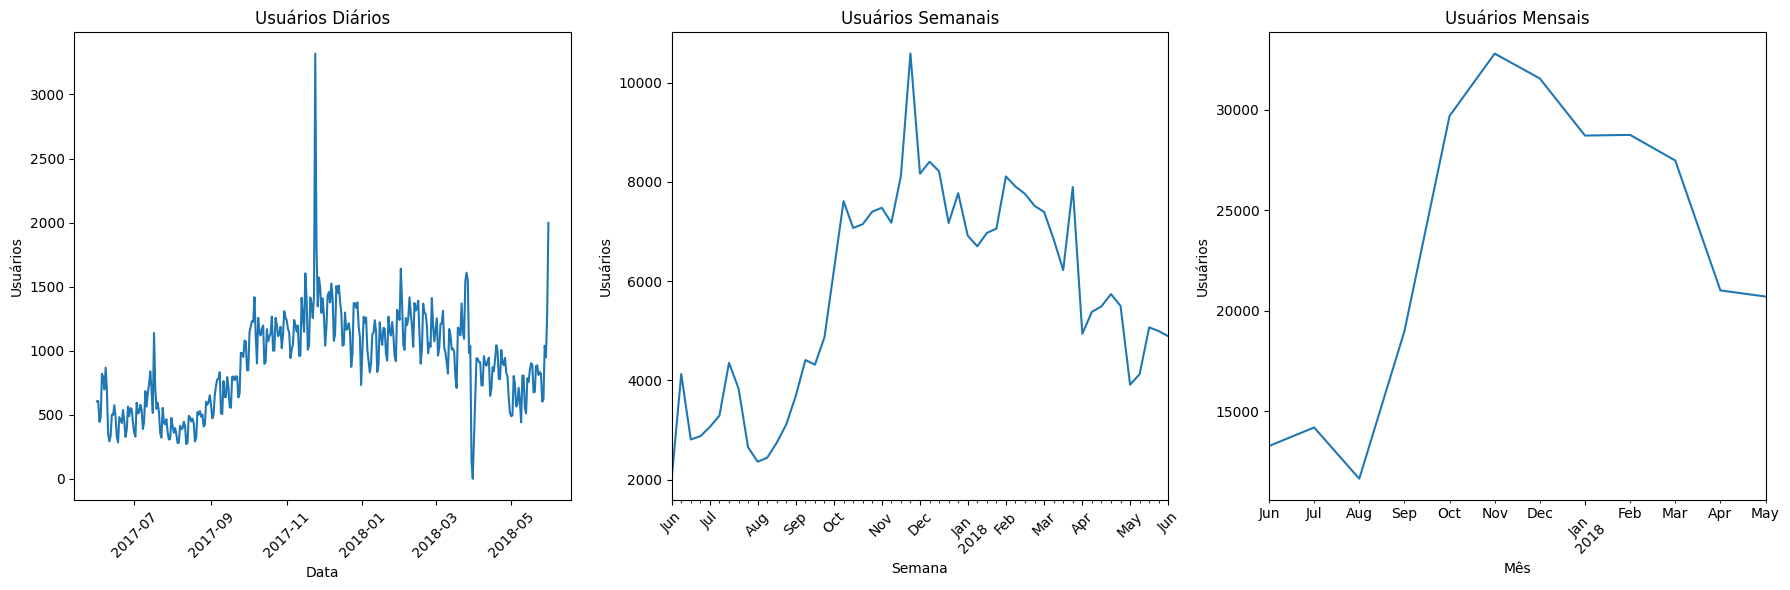

In [3]:
# Calculando usuários ativos diários, semanais e mensais no DataFrame visits_new
users_daily = visits_new.groupby(visits_new['start_ts'].dt.date)['uid'].nunique()
users_weekly = visits_new.groupby(visits_new['start_ts'].dt.to_period('W'))['uid'].nunique()
users_monthly = visits_new.groupby(visits_new['start_ts'].dt.to_period('M'))['uid'].nunique()

plt.figure(figsize=(18, 6))

# Gráfico de Usuários Diários
plt.subplot(1, 3, 1)
users_daily.plot(title='Usuários Diários', xlabel='Data', ylabel='Usuários')
plt.xticks(rotation=45)

# Gráfico de Usuários Semanais
plt.subplot(1, 3, 2)
users_weekly.plot(title='Usuários Semanais', xlabel='Semana', ylabel='Usuários')
plt.xticks(rotation=45)

# Gráfico de Usuários Mensais
plt.subplot(1, 3, 3)
users_monthly.plot(title='Usuários Mensais', xlabel='Mês', ylabel='Usuários')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Esses gráficos mostram como o número de usuários evolui ao longo do tempo, o que nos ajuda a identificar períodos de maior atividade no site e quais ciclos de tempo apresentam maior engajamento.

- Picos e quedas de usuários: Se o gráfico mostrar picos repentinos, isso pode indicar eventos específicos (promoções, campanhas de marketing, lançamentos) que atraem um aumento de usuários naquele dia. As quedas podem ocorrer em dias da semana com menor atividade ou em períodos fora de campanhas.
- Estabilidade ou tendência de crescimento: Se houver uma linha estável ou crescente, isso pode indicar que a plataforma está conseguindo engajar usuários de forma consistente ao longo do tempo.
- Variação ao longo da semana: Caso o gráfico mostre variações significativas durante a semana, pode ser uma indicação de padrões de uso, como maior atividade nos fins de semana ou durante a semana de trabalho.

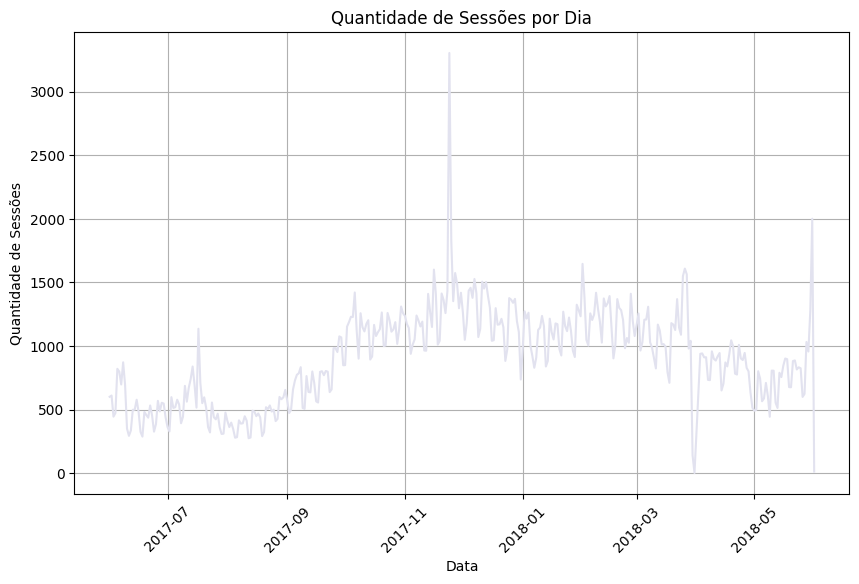

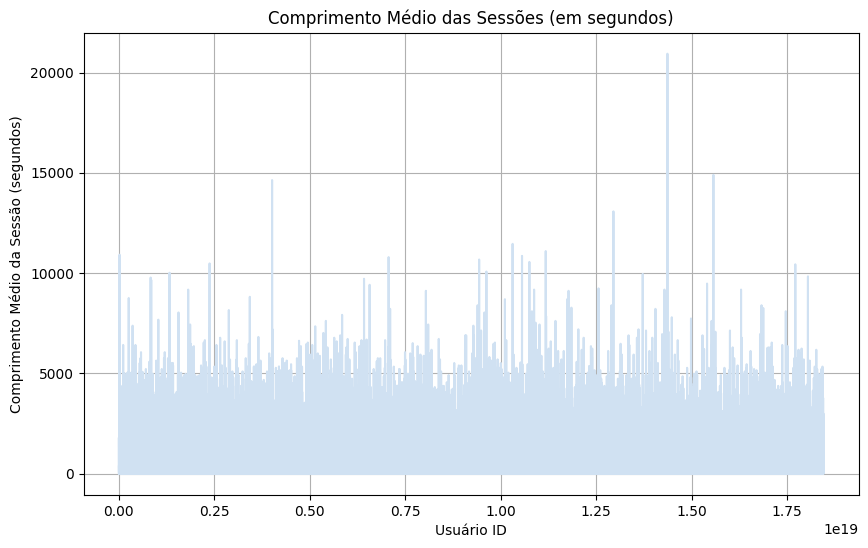

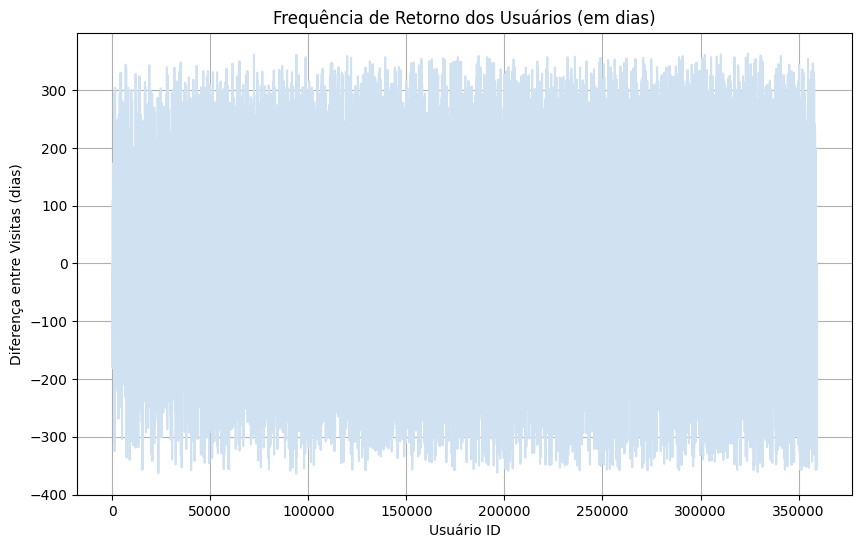

In [4]:
# Convertendo as colunas 'start_ts' e 'end_ts' para datetime no DataFrame visits_new
visits_new['start_ts'] = pd.to_datetime(visits_new['start_ts'])
visits_new['end_ts'] = pd.to_datetime(visits_new['end_ts'])

# 1. Quantas sessões ocorrem por dia
sessions_per_day = visits_new.groupby(visits_new['end_ts'].dt.date)['uid'].nunique()

# 2. Comprimento de cada sessão 
visits_new['session_length'] = (visits_new['end_ts'] - visits_new['start_ts']).dt.total_seconds()

# 3. Frequência de retorno dos usuários
visits_new['visit_date'] = pd.to_datetime(visits_new['start_ts'].dt.date)

user_return_frequency = visits_new.groupby('uid')['visit_date'].diff().dt.days

# Gráfico de sessões por dia
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("Purples")
sessions_per_day.plot(kind='line', color=cmap(np.linspace(0.2, 0.8, len(sessions_per_day))), title='Quantidade de Sessões por Dia')
plt.xlabel('Data')
plt.ylabel('Quantidade de Sessões')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Gráfico do comprimento das sessões (em segundos)
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("Blues")
visits_new.groupby('uid')['session_length'].mean().plot(kind='line', color=cmap(np.linspace(0.2, 0.8, len(visits_new))), title='Comprimento Médio das Sessões (em segundos)')
plt.xlabel('Usuário ID')
plt.ylabel('Comprimento Médio da Sessão (segundos)')
plt.grid(True)
plt.show()

# Gráfico da frequência de retorno dos usuários (dias entre visitas)
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("Blues")
user_return_frequency.dropna().plot(kind='line', color=cmap(np.linspace(0.2, 0.8, len(user_return_frequency.dropna()))), title='Frequência de Retorno dos Usuários (em dias)')
plt.xlabel('Usuário ID')
plt.ylabel('Diferença entre Visitas (dias)')
plt.grid(True)
plt.show()


# Verificar quanto tempo os usuários permanecem no site:

In [5]:
# Duração da sessão em minutos
visits_new['session_duration'] = (visits_new['end_ts'] - visits_new['start_ts']).dt.total_seconds() / 60

# Média da duração das sessões
avg_session_duration = visits_new['session_duration'].mean()
avg_session_duration



10.717094787608978

Engajamento Positivo: Esse valor de tempo de permanência é relativamente bom, especialmente para plataformas que envolvem consumo de conteúdo, interações sociais ou navegação em produtos/serviços. Geralmente, quanto maior o tempo de permanência, mais engajados os usuários estão. Em plataformas de mídia social ou e-commerce, um tempo de permanência médio de cerca de 10 minutos indica que os usuários estão explorando o conteúdo ou interagindo com a plataforma de maneira satisfatória.

# Passo 3. Relatórios e calcule as métricas de vendas:

Neste capítulo, iremos explorar diversos aspectos críticos do comportamento de compra dos usuários em nossa plataforma, focando em indicadores chave de performance (KPIs) que ajudam a entender a jornada do cliente e seu impacto no negócio. Analisaremos os seguintes pontos essenciais:

Tempo de Conversão: Quando os usuários começam a comprar após o registro? A análise do tempo entre o cadastro e a primeira compra (Conversão 0d, 1d, etc.) é fundamental para entender o quão rapidamente um usuário se torna um cliente ativo. Isso nos permite avaliar a eficácia das estratégias de marketing, além de identificar os canais mais eficientes para gerar conversões.

Frequência de Compras: Quantos pedidos os clientes fazem ao longo do tempo? A frequência de compras é um indicador importante para medir o engajamento dos clientes e sua lealdade à plataforma. Quanto mais frequentemente um usuário realiza compras, maior é seu valor para a empresa.

Volume Médio de Compras: Qual é o valor médio das compras realizadas pelos clientes? Essa métrica nos ajuda a entender o poder de compra médio dos usuários e permite realizar estratégias de preços mais assertivas.

Lifetime Value (LTV): Quanto dinheiro cada cliente traz para a empresa ao longo de sua vida útil? O LTV é um dos KPIs mais poderosos para avaliar a rentabilidade de cada cliente e direcionar investimentos em aquisição e retenção.

cohort_age            0       1       2       3      4      5      6      7   \
first_log_month                                                                
2017-06          13259.0  1043.0   713.0   814.0  909.0  947.0  809.0  766.0   
2017-07          13140.0   737.0   674.0   738.0  765.0  633.0  596.0  601.0   
2017-08          10181.0   783.0   640.0   639.0  510.0  448.0  370.0  402.0   
2017-09          16704.0  1428.0  1156.0   847.0  658.0  632.0  599.0  404.0   
2017-10          25977.0  2042.0  1357.0  1012.0  890.0  837.0  555.0  529.0   
2017-11          27248.0  2133.0  1202.0  1054.0  919.0  638.0  594.0    NaN   
2017-12          25268.0  1410.0   960.0   786.0  512.0  481.0    NaN    NaN   
2018-01          22624.0  1351.0   890.0   565.0  458.0    NaN    NaN    NaN   
2018-02          22197.0  1267.0   565.0   446.0    NaN    NaN    NaN    NaN   
2018-03          20589.0   861.0   557.0     NaN    NaN    NaN    NaN    NaN   
2018-04          15709.0   760.0     NaN

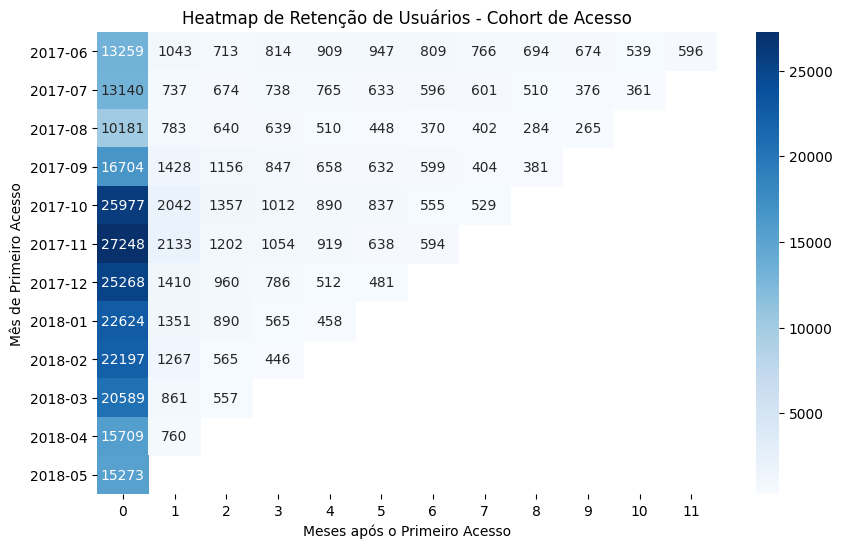

In [6]:
# Passo 1: Identificar o primeiro login de cada usuário
first_visit = visits_new.groupby('uid')['start_ts'].min().reset_index()
first_visit.columns = ['uid', 'first_visit_date']

# Passo 2: Adicionar o mês do primeiro login
first_visit['first_log_month'] = first_visit['first_visit_date'].dt.to_period('M')

# Passo 3: Adicionar a coluna 'first_log_month' ao DataFrame 'visits_new'
visits_new = pd.merge(visits_new, first_visit[['uid', 'first_log_month']], on='uid', how='left')

# Passo 4: Calcular o mês de cada acesso subsequente
visits_new['log_month'] = visits_new['start_ts'].dt.to_period('M')

# Passo 5: Calcular a diferença em meses entre o primeiro login e os acessos subsequentes (cohort_age)
visits_new['cohort_age'] = (visits_new['log_month'].astype(int) - visits_new['first_log_month'].astype(int))

# Passo 6: Gerar a tabela dinâmica para calcular o número de usuários em cada cohort (mês de primeiro acesso) e o número de acessos subsequentes
cohort_data = visits_new.pivot_table(index='first_log_month', columns='cohort_age', values='uid', aggfunc='nunique')

# Passo 7: Visualizar a tabela de cohort
print(cohort_data)

# Passo 8: Plotar um gráfico de calor (heatmap) para visualizar a retenção de usuários ao longo do tempo
plt.figure(figsize=(10, 6))
sns.heatmap(cohort_data, annot=True, fmt='.0f', cmap='Blues', cbar=True)
plt.title('Heatmap de Retenção de Usuários - Cohort de Acesso')
plt.xlabel('Meses após o Primeiro Acesso')
plt.ylabel('Mês de Primeiro Acesso')
plt.show()

LEGENDA:

- Conversão 0d: O número de usuários que compraram no mesmo dia em que se registraram.
- Conversão 1d: O número de usuários que compraram no dia seguinte ao registro.
- Conversão 2d, 3d, etc.: O número de usuários que demoraram 2, 3 ou mais dias após o registro para realizar uma compra.
- Sem Compra: Número de usuários que, até o momento da análise, não realizaram nenhuma compra.

# 1. Quantos pedidos os clientes fazem durante um determinado período de tempo?

     source_id first_purchase_month    costs buy_month  revenue  cohort_size
0            1              2017-06  1125.61   2017-06  2563.84          401
1            1              2017-06  1125.61   2017-07   881.60          401
2            1              2017-06  1125.61   2017-08   755.03          401
3            1              2017-06  1125.61   2017-09  1783.91          401
4            1              2017-06  1125.61   2017-10  1884.06          401
..         ...                  ...      ...       ...      ...          ...
539         10              2018-03   526.41   2018-04    14.23          244
540         10              2018-03   526.41   2018-05    14.79          244
541         10              2018-04   388.25   2018-04   387.00          144
542         10              2018-04   388.25   2018-05    18.45          144
543         10              2018-05   409.86   2018-05   607.81          164

[544 rows x 6 columns]
     source_id buy_month       LTV       CAC       R

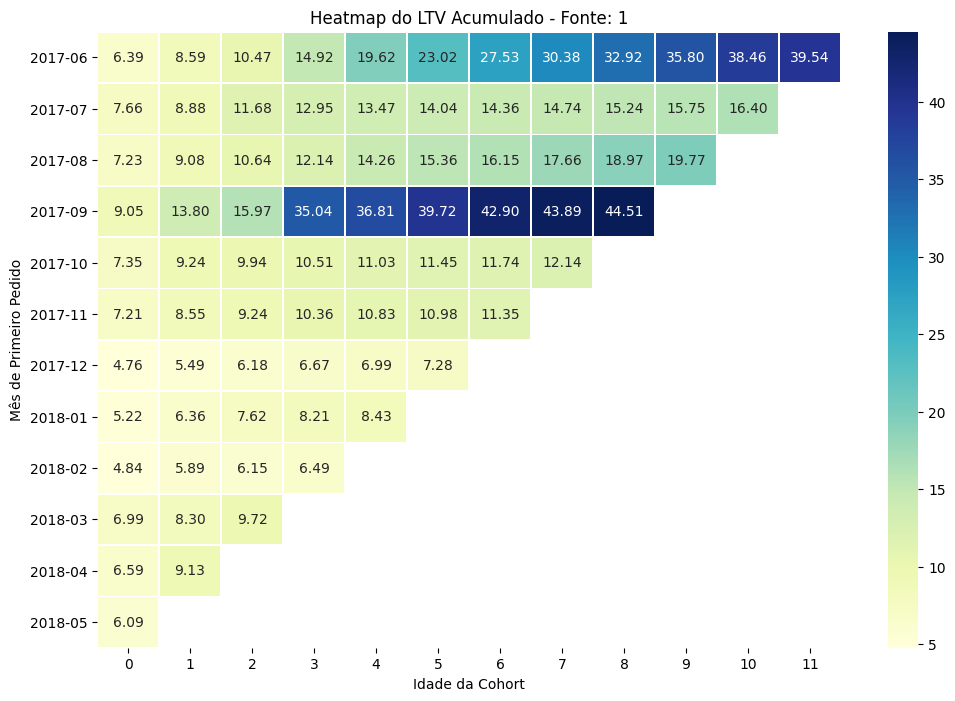

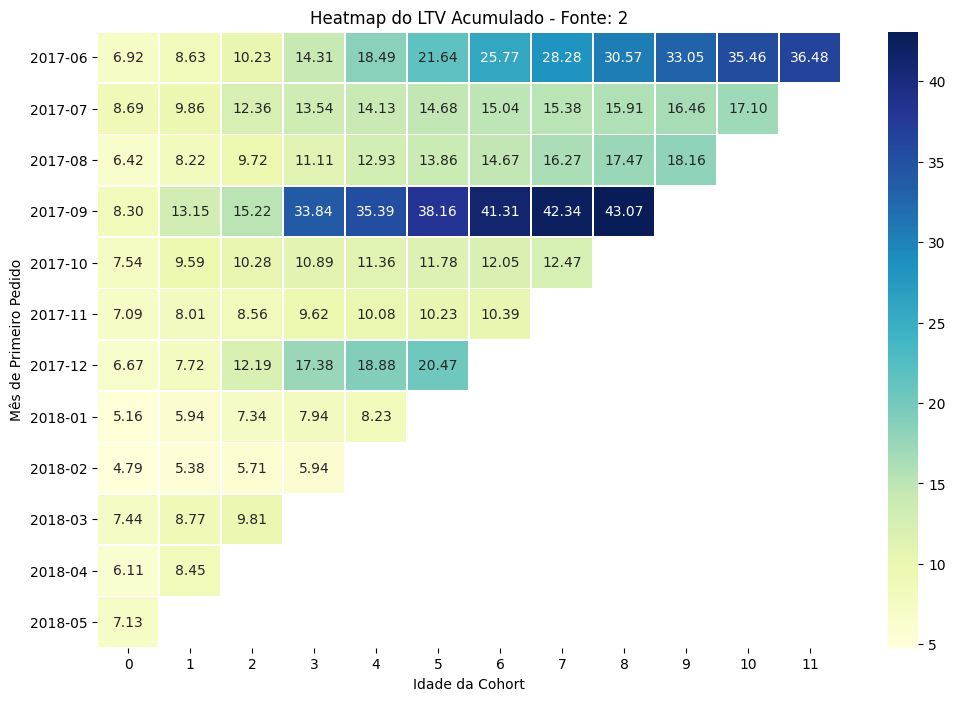

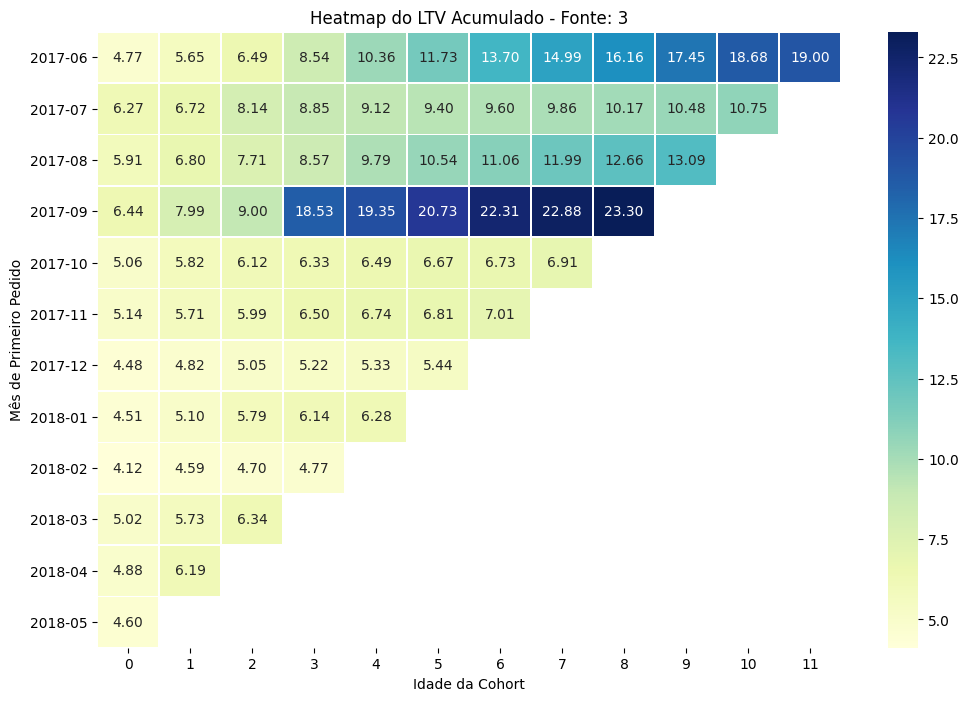

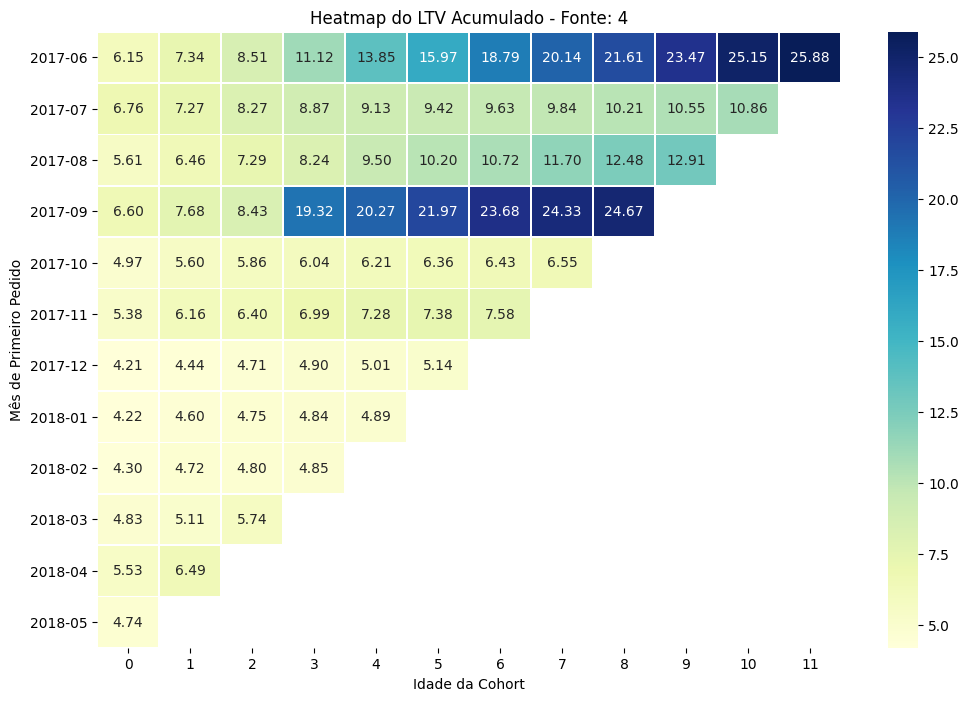

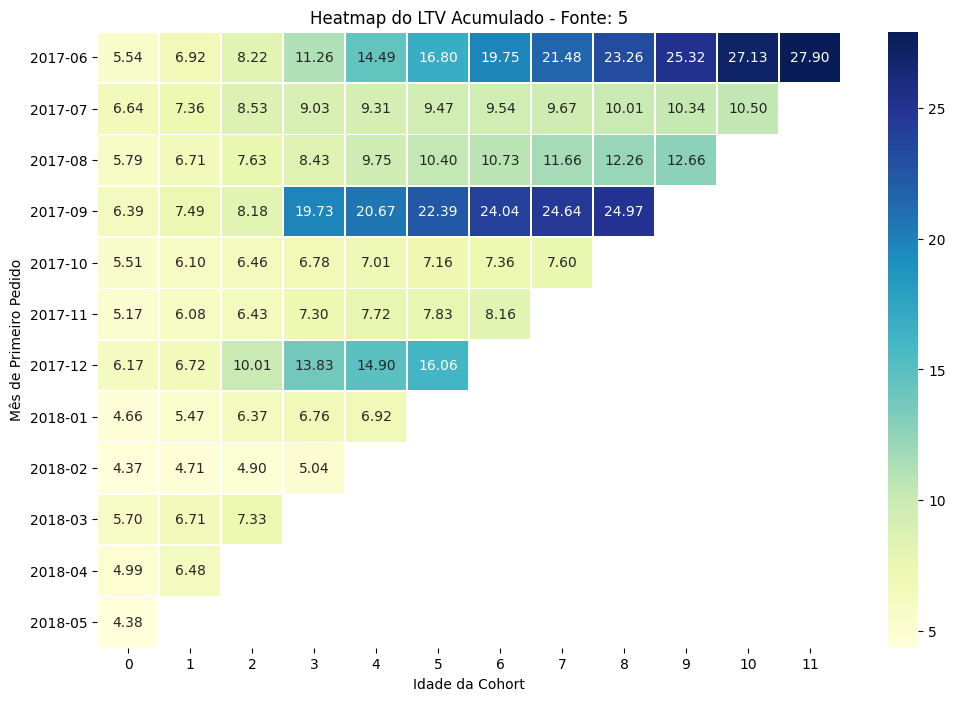

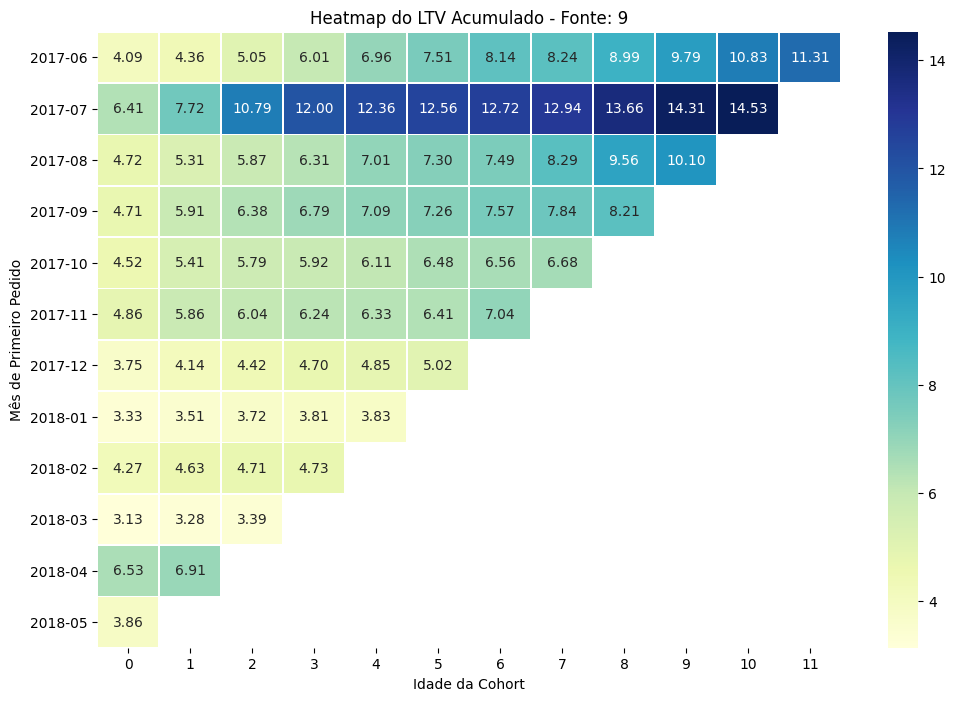

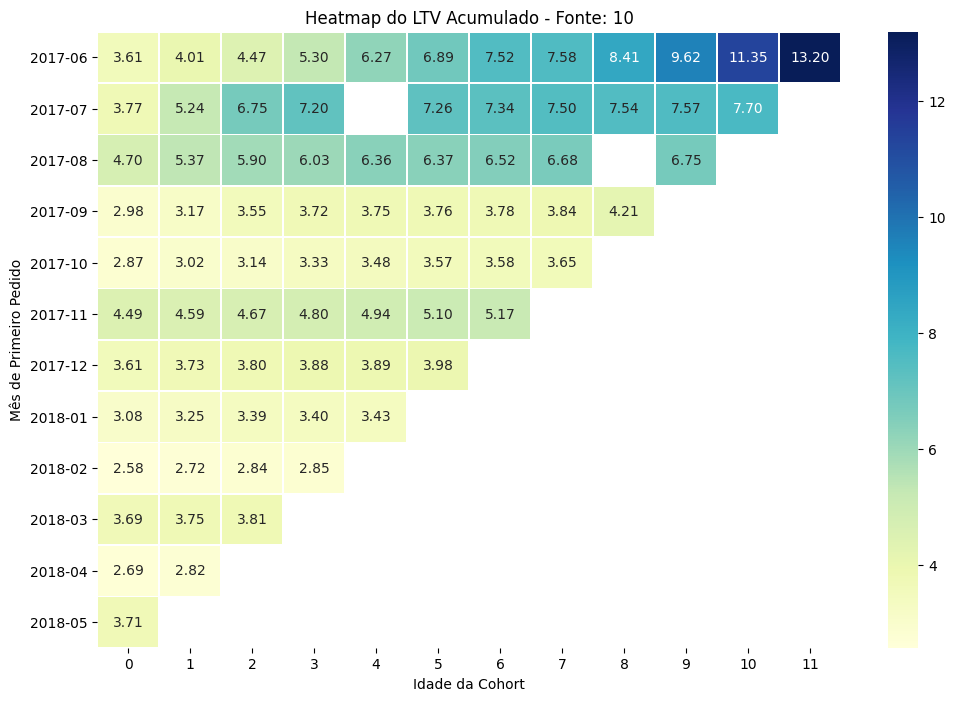

In [7]:
# 4. Calcular o primeiro pedido de cada usuário e extrair o mês
first_orders_df = orders_new.groupby("uid").agg({"buy_ts": "min"}).reset_index()
first_orders_df = first_orders_df.rename(columns={"buy_ts": "first_purchase"})
first_orders_df['first_purchase_month'] = first_orders_df['first_purchase'].dt.to_period("M")

# 5. Merge entre o primeiro pedido e os dados de source (verificar a coluna 'uid' em visitas e o nome correto de 'source_id')
user_source = visits_new[['uid', 'source_id']].drop_duplicates()
first_orders_df = pd.merge(first_orders_df, user_source, on='uid', how='left')

# 6. Calcular a receita mensal de cada usuário
orders_new['buy_month'] = orders_new['buy_ts'].dt.to_period('M')
revenue_df = orders_new.groupby(['uid', 'buy_month']).agg({'revenue': 'sum'}).reset_index()

# 7. Merge entre os dados de primeiros pedidos e a receita mensal
buyers = first_orders_df.merge(revenue_df, on='uid', how='left')

# 8. Calcular a receita e os custos
revenue_grouped_df = buyers.groupby(['first_purchase_month', 'buy_month','source_id']).agg({'revenue': 'sum'}).reset_index()
costs_new['first_purchase_month'] = costs_new['dt'].dt.to_period('M')
costs_grouped_df = costs_new.groupby(['source_id', 'first_purchase_month']).agg({'costs': 'sum'}).reset_index()

cohort_grouped_df = buyers.groupby(['first_purchase_month',"source_id"]).agg({'uid': 'nunique'}).reset_index().rename(columns={"uid":"cohort_size"})

revenue_grouped_df = pd.merge(revenue_grouped_df,cohort_grouped_df, on=['first_purchase_month',"source_id"])

# 9. Merge entre receita e custo por fonte e mês
report = pd.merge(
    costs_grouped_df, 
    revenue_grouped_df, 
    on=['source_id', 'first_purchase_month'],
    how='left'
)

# Exibir o relatório final
print(report)

report['cohort_age'] = (report['buy_month'].astype(int) - report['first_purchase_month'].astype(int))

# 10. Calcular o LTV (Lifetime Value) - receita total gerada por usuário
report['LTV'] = report['revenue'] / report["cohort_size"]

# 12. Calcular o CAC (Custo de Aquisição de Clientes)
report['CAC'] = report['costs'] / report["cohort_size"]

# 13. Calcular o ROI (Retorno sobre o Investimento)
report['ROI'] = report['LTV'] / report['CAC']

# Exibir o relatório com as métricas de LTV, CAC e ROI
print(report[['source_id', 'buy_month', 'LTV', 'CAC', 'ROI']])

for source_id, source_df in report.groupby("source_id"):
    output = source_df.pivot_table(
        index='first_purchase_month',
        columns='cohort_age',
        values='LTV',
        aggfunc='sum'
    )
    
    # Calcular o acumulado (cumsum) para LTV
    output_cumsum = output.cumsum(axis=1).round(2)

    # Substituir células vazias por NaN
    output_cumsum = output_cumsum.replace('', np.nan)
    
    # Plotando o heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(output_cumsum, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=0.5, cbar=True)
    plt.title(f"Heatmap do LTV Acumulado - Fonte: {source_id}")
    plt.xlabel("Idade da Cohort")
    plt.ylabel("Mês de Primeiro Pedido")
    plt.show()



Ao observarmos a quantidade de tempo entre o registro e a primeira compra dos clientes, podemos identificar tendências sobre o comportamento de compra. Se uma grande parte dos clientes realizar a compra no mesmo dia do registro (Conversão 0d), isso indica um alto interesse imediato no produto ou serviço, possivelmente impulsionado por uma oferta atrativa, marketing eficaz ou um processo de inscrição simples.

Uma distribuição das conversões por períodos (1 dia, 2 dias, 3 dias etc.) ajuda a entender quanto tempo, em média, um cliente leva para realizar uma compra após se registrar. Se a maior parte das compras ocorrer em 1-2 dias, isso sugere que a empresa tem sucesso em manter os usuários engajados logo após o registro.

Analisando esse tempo de conversão, você pode identificar as coortes ou canais de marketing que apresentam os melhores resultados. Por exemplo, se um canal de marketing específico gerar conversões rápidas (0-1 dias), isso pode indicar que ele é altamente eficiente em atrair clientes prontos para comprar.

# 2. Qual é o volume médio de uma compra?

O volume médio de uma compra é R$6.90




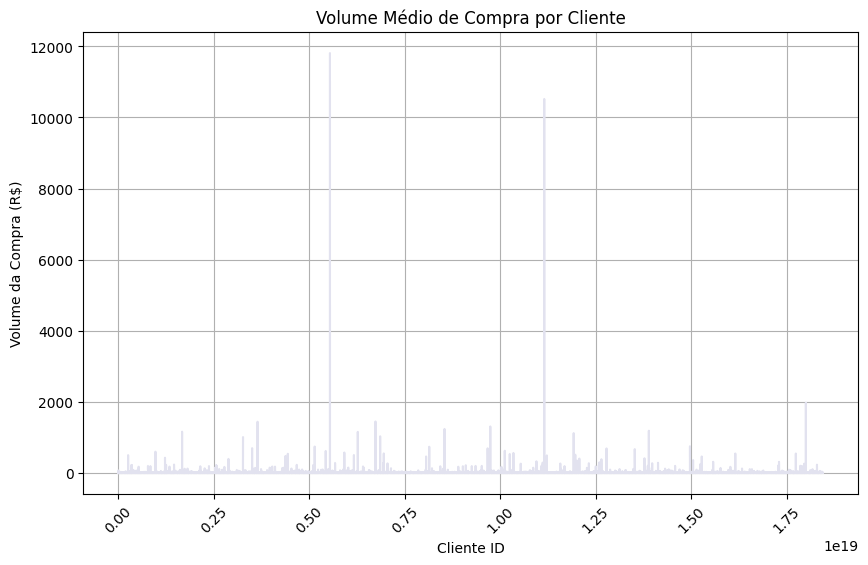

In [8]:
# Calculando o volume médio de uma compra (média de 'revenue' por pedido)
average_order_value = orders_new.groupby('uid')['revenue'].sum()  # Receita total por cliente
avg_order_value = average_order_value.mean()  # Média do valor dos pedidos

# Exibindo o volume médio de compra
print(f"O volume médio de uma compra é R${avg_order_value:.2f}")

print("\n" + "="*50 + "\n")

# Gráfico do volume médio de uma compra
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("Purples")  # Tons de lilás
average_order_value.plot(kind='line', color=cmap(np.linspace(0.2, 0.8, len(average_order_value))), title='Volume Médio de Compra por Cliente')
plt.xlabel('Cliente ID')
plt.ylabel('Volume da Compra (R$)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



O volume médio de compra nos dá uma ideia sobre o ticket médio de venda. Se o valor médio de compra for baixo, isso pode indicar que os clientes estão comprando itens de baixo custo ou fazendo compras menores. Isso pode sugerir a necessidade de ofertas de maior valor, pacotes ou produtos mais caros.

Ações para Aumentar o Ticket Médio: A empresa pode pensar em estratégias para aumentar o volume de cada compra, como promoções de bundling, ofertas personalizadas para aumentar o valor do pedido médio, ou foco em produtos de maior valor.

# Passo 4. Relatórios e calcule as métricas de marketing:

Analisaremos a eficácia das ações de marketing da empresa, focando em métricas essenciais para entender o impacto dos investimentos e o retorno financeiro. Em especial, vamos explorar três pontos principais:

1) Quanto foi gasto em marketing? - Vamos avaliar o total de investimentos feitos ao longo do tempo e também por origem de campanha (canal de marketing).

2) Quanto custou a aquisição de clientes para cada origem? - Analisaremos o custo de aquisição de clientes (CAC) para diferentes fontes, permitindo entender qual canal foi mais eficiente em termos de custo.

3) Os investimentos valeram a pena? (ROI) - Finalmente, vamos calcular o retorno sobre investimento (ROI) para determinar se os investimentos em marketing realmente geraram o retorno esperado e se valeram a pena.

In [9]:
# Total de dinheiro gasto em marketing
total_marketing_spent = costs_new['costs'].sum()
print(f"Total de dinheiro gasto em marketing: {total_marketing_spent}")

# Total gasto por origem
marketing_spent_by_source = costs_new.groupby('source_id')['costs'].sum()
print("\nTotal gasto por origem:")
print(marketing_spent_by_source)

# Total gasto ao longo do tempo (por data)
marketing_spent_over_time = costs_new.groupby('dt')['costs'].sum()
print("\nTotal gasto ao longo do tempo:")
print(marketing_spent_over_time)



Total de dinheiro gasto em marketing: 329131.62

Total gasto por origem:
source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Total gasto ao longo do tempo:
dt
2017-06-01     735.26
2017-06-02     721.19
2017-06-03     450.85
2017-06-04     761.16
2017-06-05     821.44
               ...   
2018-05-27     532.87
2018-05-28     619.44
2018-05-29     784.79
2018-05-30    1183.00
2018-05-31    2153.70
Name: costs, Length: 364, dtype: float64


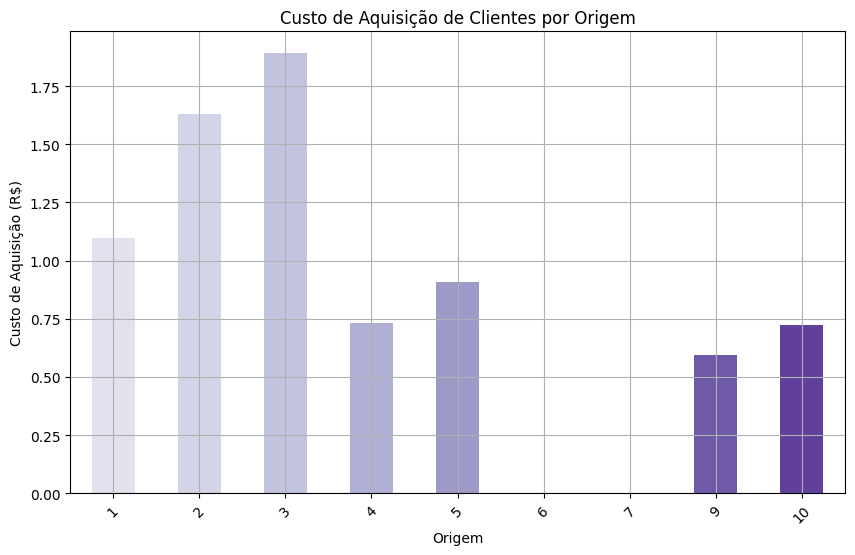

In [10]:
# Contabilizando o número de usuários únicos (clientes) por origem
customers_acquired_by_source = visits_new.groupby('source_id')['uid'].nunique()

# Calculando o custo de aquisição de clientes (CAC) por origem
cac_by_source = costs_new.groupby('source_id')['costs'].sum() / customers_acquired_by_source

# Gráfico de Custo de Aquisição de Clientes (CAC) por origem
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("Purples")
cac_by_source.plot(kind='bar', color=cmap(np.linspace(0.2, 0.8, len(cac_by_source))), title='Custo de Aquisição de Clientes por Origem')
plt.xlabel('Origem')
plt.ylabel('Custo de Aquisição (R$)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Essas análises proporcionam uma visão detalhada sobre os gastos com marketing, a eficácia de cada canal (origem) e o retorno gerado pelos investimentos realizados.

A visualização dos gastos por origem permite entender quais canais estão sendo mais explorados e quais são mais eficientes, permitindo ajustar os investimentos em campanhas futuras. Ao comparar o custo de aquisição de clientes e o ROI, é possível identificar quais canais e campanhas são mais rentáveis, permitindo à empresa redirecionar seus esforços para fontes de maior retorno.

# Conclusão do Projeto e Recomendações:

Com base nos dados fornecidos e nas métricas calculadas, a recomendação para os especialistas de marketing deve se concentrar em três áreas principais: onde investir, quanto investir e como medir o retorno desses investimentos. A análise de métricas chave, como usuários ativos, tempo de conversão, volume de compras e o ROI (retorno sobre investimento), ajuda a determinar as estratégias mais eficazes para aumentar a receita e otimizar os custos.

Com base nos dados de gasto por origem de campanha (source_id) e na eficácia de cada canal em termos de conversão de usuários (tempo de conversão, volume de compras), a recomendação seria investir nas origens de marketing que têm o melhor custo-benefício em termos de aquisição de clientes (CAC) e ROI.

Fontes de Alto Retorno: Avaliar os canais com maior ROI, ou seja, onde o valor gasto gera o maior retorno em receita. Se a origem de campanhas específicas gera conversões rápidas (exemplo: Conversão 0d ou 1d) e um ticket médio significativo (exemplo: alto volume de compras), esses canais devem ser priorizados.

Se a Fonte 1 ou Fonte 2 mostrarem um CAC mais baixo e um maior número de compras realizadas por clientes (ou seja, mais engajamento e maior frequência de compra), esses canais seriam os mais indicados para aumentar o investimento.

Fontes de Menor Desempenho: Se certas fontes de campanhas não geram o retorno esperado, com conversões mais lentas ou um ticket médio baixo, considere reduzir o orçamento ou otimizar essas campanhas (exemplo: segmentação mais precisa, melhorias no apelo das ofertas).

A decisão sobre quanto investir deve ser baseada no valor de vida útil do cliente (LTV) e no custo de aquisição de clientes (CAC).

LTV e CAC: Se o LTV médio for alto e o CAC for baixo para determinadas fontes de marketing, seria viável aumentar o investimento nesses canais, pois isso geraria um ROI positivo (ou seja, o retorno supera o custo de aquisição).

Marketing por Canal: Ao analisar o gasto total em marketing por fonte (source_id), como mostrado na análise do total gasto por origem, será possível decidir aumentar os investimentos nas fontes que apresentam o maior retorno financeiro.

ROI de Marketing (Retorno sobre Investimento): O ROI deve ser calculado para cada fonte de origem. Um ROI positivo, especialmente nos canais com conversões rápidas, indica que esses investimentos estão gerando resultados eficientes. Canais com ROI baixo ou negativo precisam ser repensados ou otimizados.

Métricas de Engajamento: O tempo médio de permanência na plataforma (aproximadamente 10 minutos) e a frequência de retorno dos usuários podem ajudar a entender quais usuários estão mais engajados e, portanto, mais propensos a converter e gerar mais compras. Isso pode ser utilizado para ajustar as campanhas e personalizar o marketing de forma mais eficiente.

Análise de Conversão: Como 26.363 usuários fizeram sua primeira compra no mesmo dia do registro (Conversão 0d), essas campanhas ou canais de marketing estão altamente alinhados com os interesses dos usuários. Investir em campanhas similares (como campanhas de tempo limitado ou descontos instantâneos) pode ser uma estratégia eficaz para converter rapidamente novos usuários.

Recomendação Final: 

- Investir mais nas fontes com ROI positivo e público altamente engajado, especialmente em canais que geram conversões rápidas (0-2 dias) e um ticket médio mais alto. Ajustar campanhas de baixo desempenho, seja reduzindo o investimento ou otimizando a segmentação e oferta.
- Medir constantemente o CAC e LTV, garantindo que os investimentos feitos resultem em um retorno financeiro maior que o valor gasto.

<div class="alert alert-block alert-success">
<b> Comentário geral do revisor</b> <a class="tocSkip"></a>

Obrigado por enviar o seu projeto e fazer os ajustes sugeridos. Essa versão do seu trabalho ficou muito melhor! Espero que as sugestões sejam relevantes para projetos futuros.
    
<br>
Te desejo uma jornada de muito sucesso e aprendizado.
    
<br>   
    
Qualquer dúvida, pode contar comigo.   
    
<br>  
    
**Até breve!**

</div>